In [1]:
!pip install --upgrade --force-reinstall git+https://github.com/FelipeSchreiber/BregmanClustering.git

  Cloning https://github.com/FelipeSchreiber/BregmanClustering.git to /tmp/pip-req-build-uz3u4p95
  Running command git clone --filter=blob:none --quiet https://github.com/FelipeSchreiber/BregmanClustering.git /tmp/pip-req-build-uz3u4p95
  Resolved https://github.com/FelipeSchreiber/BregmanClustering.git to commit 40cd47d5524a6c6ba65bb53cf8ee1a5d1f3e1a6d
  Preparing metadata (setup.py) ... done
  Created wheel for bregClust: filename=bregClust-0.1-py3-none-any.whl size=10597 sha256=89d01c38051c27a86dd9c58a4fa012a629db89f7b17bb9311676d68570f6fba3
  Stored in directory: /tmp/pip-ephem-wheel-cache-rxt3vmvq/wheels/6f/8f/ab/2faa84d8b9fad58989d72cda12225f6191888313b2d42f6ad5
Successfully built bregClust
  Attempting uninstall: bregClust
    Found existing installation: bregClust 0.1
    Uninstalling bregClust-0.1:
      Successfully uninstalled bregClust-0.1


In [2]:
%matplotlib inline
from BregmanClustering.WSBM import *
from copy import deepcopy
from sklearn.metrics import adjusted_rand_score, calinski_harabasz_score, normalized_mutual_info_score, accuracy_score
from signet.cluster import Cluster
from sklearn.manifold import spectral_embedding,SpectralEmbedding
import scipy.sparse as ss
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import pairwise_kernels
import sys
sys.path.insert(1, '/home/felipe/Documentos/CSBM-main/Python')
import functions as CSBM
import dataframe_image as dfi
import os
import warnings
from BregmanClustering import models
from BregmanClustering.models import SoftBregmanNodeAttributeGraphClustering as VEMbreg
import subprocess
warnings.filterwarnings("ignore")

In [3]:
method = 'hard'
initialization="akaike"
path = "/home/felipe/Documentos/BregmanBenchmark/data/Dreveton_benchmark/"

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 17 17:08:00 2023

@author: maximilien, Felipe Schreiber
"""
from tqdm import tqdm

SIZE_TITLE = 24
SIZE_LABELS = 24
SIZE_TICKS = 18
SIZE_LEGEND = 18

def unitRootCoordinates( d = 2, r=1 ):
    coordinates = []
    for k in range( d ):
        coordinates.append( [ r*np.cos(2*k*np.pi / d ), r*np.sin( 2*k*np.pi / d ) ])
    return coordinates

def generateData( sizes, p, mu ):
    n = sum( sizes )
    n_clusters = len( sizes )
    d = len( mu[0] )
    
    labels_true = [ ]
    for k in range( n_clusters ):
        labels_true += [ k for i in range( sizes[ k ] ) ]
    labels_true = np.asarray( labels_true, dtype = int )

    G = nx.stochastic_block_model( sizes, p )
    X = nx.adjacency_matrix( G ).todense()
    
    Y = np.zeros( ( n,d ) )
    for i in range( n ):
        Y[i,:] = np.random.normal( loc = mu[ labels_true[i] ] )
    return np.asarray(X), Y, labels_true


def plotting( x, curves, labels, xticks,
             curves_std = None,
             legendTitle = '', figTitle = '',
             xlabel = 'a', ylabel = 'ARI',
             saveFig = False, fileName = 'fig.eps'):
    
    if len( curves ) != len( labels ):
        raise TypeError( 'The number of labels is different from the number of curves' )
    
    if curves_std == None:
        for i in range( len( labels) ):
            plt.plot( x, curves[i], label = labels[i])
    else:
        for i in range( len( labels) ):
            plt.errorbar( x, curves[ i ], yerr = curves_std[ i ], linestyle = '-.', label = labels[ i ] )

    
    legend = plt.legend( title = legendTitle, loc=4,  fancybox=True, fontsize= SIZE_LEGEND )
    plt.setp( legend.get_title(),fontsize= SIZE_LEGEND )
    plt.xlabel( xlabel, fontsize = SIZE_LABELS )
    plt.ylabel( ylabel, fontsize = SIZE_LABELS )
    plt.xticks( xticks, fontsize = SIZE_TICKS )
    plt.yticks( fontsize = SIZE_TICKS )
    plt.title( figTitle, fontsize = SIZE_TITLE )
    if saveFig:
        plt.savefig( fileName, format = 'eps', bbox_inches = 'tight' )

#Somehow some errors message sometimes arises such as 
#RuntimeWarning: divide by zero encountered in log
#But this shouldn be a problem

In [5]:
c = 3
n = 100
N = c*n
delta = 10
d = 2
dim = c*d
P = np.array([[0.8, 0.2, 0.3],[0.2, 0.7, 0.4],[0.3, 0.4, 0.6]])
true_labels = [0]*n + [1]*n + [2]*n

In [6]:
X,Y = BregmanBenchmark(P,[n]*c,1,10,dims=2,weight_variance=0.01,att_variance=0.1,\
                       weight_distribution="logistic",attributes_distribution="logistic").generate_benchmark_WSBM()
A = (X != 0).astype(int)

In [7]:
X

array([[ 0.  ,  0.94,  0.95, ...,  0.  ,  4.59,  0.  ],
       [ 0.94,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.95,  0.  ,  0.  , ...,  4.48,  0.  ,  4.67],
       ...,
       [ 0.  ,  0.  ,  4.48, ...,  0.  ,  0.  ,  9.82],
       [ 4.59,  0.  ,  0.  , ...,  0.  ,  0.  , 10.07],
       [ 0.  ,  0.  ,  4.67, ...,  9.82, 10.07,  0.  ]])

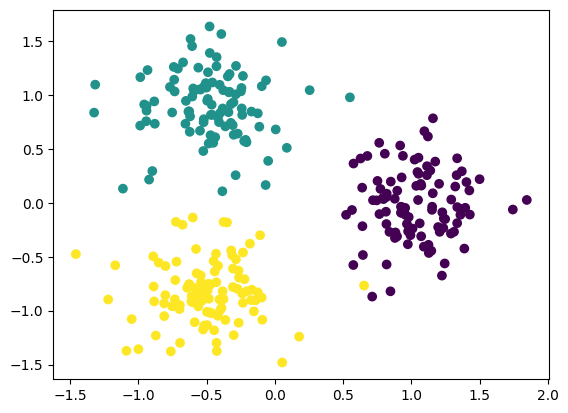

In [8]:
plt.scatter(Y[:,0],Y[:,1],c=true_labels)

In [9]:
def get_spectral_decomposition(A,k):
    if (A<0).any():
        A = pairwise_kernels(A,metric='rbf')
    U = SpectralEmbedding(n_components=k,affinity="precomputed").fit_transform(A)
    return U
def spectral(A,k):
    U = get_spectral_decomposition(A,k)
    return GaussianMixture(n_components=k).fit_predict(U.real)
pred_labels = spectral(X.copy(),c)
print(adjusted_rand_score(true_labels, pred_labels),normalized_mutual_info_score(true_labels, pred_labels))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

1.0 1.0


In [10]:
pred_labels = GaussianMixture(n_components=c).fit_predict(Y.copy())
print(adjusted_rand_score(true_labels, pred_labels),normalized_mutual_info_score(true_labels, pred_labels))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49292820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

0.9899831669528851 0.9829929733076641


In [11]:
model = models.BregmanNodeAttributeGraphClustering(n_clusters=c)
model.fit(A, Y)
z_pred_both = model.predict(A,Y)
z_pred_att = models.frommembershipMatriceToVector( model.memberships_from_attributes )
z_pred_graph = models.frommembershipMatriceToVector( model.memberships_from_graph )
print(adjusted_rand_score(true_labels, z_pred_both),normalized_mutual_info_score(true_labels, z_pred_both))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e492ac820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
number of iterations :  25
1.0 1.0


In [13]:
n_average = 30
n = 300
n_clusters = 2
d = 1
sizes = [ n // n_clusters ]*np.ones( n_clusters, dtype = int )

b = 5
pout = b * np.log( n ) / n

a_range = [ 5,7,9,11,13,15 ]
r_range = [ 0,1,2,3,4,5 ]
# a_range = [ 5,7,9]
# r_range = [ 0,1,2]

stats = {"varying":[],"a":[],"r":[],"agreed":[],"ARI_chernoff":[],"ARI_AIC":[],"ARI_ORACLE":[]}

for varying in ["attributes","graph"]:
# varying = 'attributes'
# #varying = 'graph'

    aris_attributes_mean = [ ]
    aris_graph_mean = [ ]
    aris_both_mean = [ ]
    aris_attSBM_mean = [ ]
    aris_IR_sLS_mean = [ ]
    aris_IR_LS_mean = [ ]
    aris_both2_mean = [ ]
    aris_oracle_mean = [ ]

    aris_attributes_std = [ ]
    aris_graph_std = [ ]
    aris_both_std = [ ]
    aris_attSBM_std = [ ]
    aris_IR_sLS_std = [ ]
    aris_IR_LS_std = [ ]
    aris_both2_std = [ ]
    aris_oracle_std = [ ]

    if varying == 'graph':
        loop = tqdm( range( len( a_range ) ) )
    else:
        loop = tqdm( range( len( r_range ) ) )

    for dummy in loop:
        if varying == 'graph':
            a = a_range[ dummy ]
            r = 1
        elif varying == 'attributes':
            a = 8
            r = r_range[ dummy ]
        mu = np.array([ [r], [-r] ])
        #print(mu.shape)
        #mu = unitRootCoordinates( d=2, r=r )

        pin = a * np.log( n ) / n
        p = (pin- pout) * np.eye( n_clusters ) + pout * np.ones( (n_clusters, n_clusters) )

        aris_attributes = [ ]
        aris_graph = [ ]
        aris_both = [ ]
        aris_attSBM = [ ]
        aris_IR_sLS  = [ ]
        aris_IR_LS = [ ]
        aris_both2 = [ ]
        aris_oracle = [ ]
        
        path_ = path+f"a/{a}/r/{r}/"
        if not os.path.exists(path_):
            os.makedirs(path_)

        total = 0
        for trial in range( n_average ):
            ( X, Y, z_true ) = generateData( sizes, p, mu )
            model = models.BregmanNodeAttributeGraphClustering( n_clusters = n_clusters, initializer="chernoff")
            ## For comparison purposes, the initialization is the same for IR-sLS, IR-LS and ours    
            model.initialize(X,Y)
            model.assignInitialLabels( X, Y )
            z_init = model.predicted_memberships.copy()
            chernoff_init_graph = model.graph_init
            chernoff_graph_labels = model.memberships_from_graph
            chernoff_att_labels = model.memberships_from_attributes

            with open(f'{path_}att_{trial}.npy', 'wb') as g:
                np.save(g, Y)
            with open(f'{path_}net_{trial}.npy', 'wb') as g:
                np.save(g, X)
            with open(f'{path_}z_init_{trial}.npy', 'wb') as g:
                np.save(g, CSBM.convertZ(z_init)+1)

            model.fit( X, Y )
            z_pred_both = model.predict( X, Y )
            z_pred_graph = models.frommembershipMatriceToVector( chernoff_graph_labels )
            z_pred_attributes = models.frommembershipMatriceToVector( chernoff_att_labels )
            
            if chernoff_init_graph == model.AIC_initializer(X,Y).graph_init:
                total += 1
            
            ## Warm start
            if model.graph_init:
                model.fit( X, Y, chernoff_graph_labels)
            else:
                model.fit(X, Y, chernoff_att_labels)
            
            z_pred_both2 = model.predict( X, Y )
            #model2 = VEMbreg(n_clusters=n_clusters, normalize_=True, thresholding=True)
            
            IR_sLS_pred = CSBM.iter_csbm(X,Y,z_init,n_clusters)
            IR_LS_pred = CSBM.iter_csbm2(X,Y,z_init,n_clusters)
                
            subprocess.call(["Rscript" ,"--vanilla","run_AttSBM.r",\
                            f'{path_}att_{trial}.npy',\
                            f'{path_}net_{trial}.npy',\
                            f'{path_}z_init_{trial}.npy'])

            attSBMPred = np.load("predict.npy")

            aris_attributes.append( adjusted_rand_score( z_true, z_pred_attributes ) )
            aris_graph.append( adjusted_rand_score( z_true, z_pred_graph ) )
            aris_both.append( adjusted_rand_score( z_true, z_pred_both ) )
            aris_attSBM.append( adjusted_rand_score( z_true, attSBMPred ) )
            aris_IR_sLS.append( adjusted_rand_score( z_true, IR_sLS_pred ) )
            aris_IR_LS.append( adjusted_rand_score( z_true, IR_LS_pred ) )
            aris_both2.append( adjusted_rand_score( z_true, z_pred_both2 ))
            
            if chernoff_init_graph != model.AIC_initializer(X,Y).graph_init:
                ## both initializations were done
                aris_oracle.append( max(aris_both[-1],aris_both2[-1]))
            elif chernoff_init_graph:
                z_pred_att_init = model.fit(X,Y,chernoff_att_labels).predict(X,Y)
                ari_att_init = adjusted_rand_score( z_true, z_pred_att_init)
                aris_oracle.append( max(aris_both[-1], ari_att_init))
            elif not chernoff_init_graph:
                z_pred_graph_init = model.fit(X,Y,chernoff_graph_labels).predict(X,Y)
                ari_graph_init = adjusted_rand_score( z_true, z_pred_graph_init)
                aris_oracle.append( max(aris_both[-1], ari_graph_init))
                
        aris_attributes_mean.append( np.mean( aris_attributes ) )
        aris_graph_mean.append( np.mean( aris_graph ) )
        aris_both_mean.append( np.mean( aris_both ) )
        aris_attSBM_mean.append( np.mean( aris_attSBM ) )
        aris_IR_sLS_mean.append( np.mean( aris_IR_sLS ) )
        aris_IR_LS_mean.append( np.mean( aris_IR_LS ) )
        aris_both2_mean.append( np.mean( aris_both2) )
        aris_oracle_mean.append( np.mean( aris_oracle) )
        
        aris_attributes_std.append( np.std( aris_attributes ) )
        aris_graph_std.append( np.std( aris_graph ) )
        aris_both_std.append( np.std( aris_both ) )
        aris_attSBM_std.append( np.std( aris_attSBM ) )
        aris_IR_sLS_std.append( np.std( aris_IR_sLS ) )
        aris_IR_LS_std.append( np.std( aris_IR_LS ) )
        aris_both2_std.append( np.std( aris_both2 ) )
        aris_oracle_std.append( np.std( aris_oracle) )
        
        stats["varying"].append(varying)
        stats["a"].append(a)
        stats["r"].append(r)
        stats["agreed"].append(total/n_average)
        stats["ARI_chernoff"].append(aris_both_mean[-1])
        stats["ARI_AIC"].append(aris_both2_mean[-1])
        stats["ARI_ORACLE"].append(aris_oracle_mean[-1])
        
    curves = [ aris_attributes_mean, aris_graph_mean,\
              aris_both_mean , aris_attSBM_mean, aris_IR_sLS_mean,\
              aris_IR_LS_mean, aris_both2_mean]

    curves_std = [ aris_attributes_std, aris_graph_std,\
                  aris_both_std , aris_attSBM_std, aris_IR_sLS_std,\
                  aris_IR_LS_std, aris_both2_std]

    labels = [ 'attributes', 'graph', 'both' , 'attSBM', 'IR_sLS', 'IR_LS', "both2"]
    saveFig = True
    if varying == 'graph':    
        fileName = 'N_' + str(n) + '_K_' + str(n_clusters) + '_b_' + str(b) + '_r_' + str(r) +  '_nAverage' + str(n_average) + '.eps'
        plotting( a_range, curves, labels, curves_std = curves_std, xticks = a_range, xlabel = 'a', saveFig = saveFig, fileName = fileName )
        plt.close()
    elif varying == 'attributes':
        fileName = 'N_' + str(n) + '_K_' + str(n_clusters) + '_a_' + str(a) + '_b_' + str(b) +  '_nAverage_' + str(n_average) + '.eps'
        plotting( r_range, curves, labels, curves_std = curves_std, xticks = r_range, xlabel = 'r', saveFig = saveFig, fileName = fileName )
        plt.close()

  0%|                                                     | 0/6 [00:00<?, ?it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback fun

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5edc10>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d5e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5edc10>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666de50>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5edc10>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5edc10>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490deaf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e53d5e430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5edc10>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e53d5e430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e53d5e430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e53d5e430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e53d5e430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d790>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7595e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194310>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194310>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


 17%|███████▎                                    | 1/6 [05:47<28:58, 347.79s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback fun

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5c3c65e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e491949d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194a60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e491949d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5edc10>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5edc10>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5edc10>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5edc10>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5edc10>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5edc10>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666df70>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666df70>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666de50>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666df70>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666df70>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666df70>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666de50>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666de50>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666df70>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666de50>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666df70>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666de50>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666df70>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666de50>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666df70>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666de50>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666df70>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666de50>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b7590d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194e50>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


 50%|██████████████████████                      | 3/6 [17:16<17:18, 346.21s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback fun

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e491944c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e491944c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e491944c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e491944c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194e50>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194e50>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194e50>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194790>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194e50>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194e50>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194e50>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e491949d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e491949d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194a60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194a60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194a60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


 67%|█████████████████████████████▎              | 4/6 [23:22<11:47, 353.95s/it]

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666ddc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666df70>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666df70>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5edc10>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


 83%|████████████████████████████████████▋       | 5/6 [29:43<06:03, 363.56s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback fun

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b4823a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490de9d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d5e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d790>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d790>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d5e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666df70>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5ba45280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053baf0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666dee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d790>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d790>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e9053b1f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d790>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b759160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e46c35ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


100%|████████████████████████████████████████████| 6/6 [35:52<00:00, 358.77s/it]

number of iterations :  25



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
  0%|                                                     | 0/6 [00:00<?, ?it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e328b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e328b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e328b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e328b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670958b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670953a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095310>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66dc0dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66dc0700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66dc0700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66dc0700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


 33%|██████████████▋                             | 2/6 [10:32<21:17, 319.41s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback fun

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66dc0dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66dc0700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66dc0700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Initialisation chosen from the graph
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66dc0dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670955e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670953a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670953a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670958b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670958b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e329d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e329d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e329d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e329d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e25160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e25160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e25160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e329d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e329d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e25160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e25160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e329d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e25160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e329d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


 50%|██████████████████████                      | 3/6 [17:23<18:04, 361.36s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback fun

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e329d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e329d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e329d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e329d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e329d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e329d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32ee0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670953a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095310>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670955e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


 67%|█████████████████████████████▎              | 4/6 [24:50<13:09, 394.83s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback fun

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095310>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095700>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095310>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670958b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670958b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095430>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670958b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670958b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670955e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670958b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670958b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670955e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670958b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670955e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670958b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670958b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670958b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095550>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670955e0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095310>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the attributes


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095310>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095790>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d3a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e670958b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095790>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


 83%|████████████████████████████████████▋       | 5/6 [32:36<07:00, 420.50s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback fun

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095790>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e3666d4c0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095310>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095790>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095310>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095310>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095790>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e490dea60>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095790>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095790>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66dc0790>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66dc0280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e67095310>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66dc0280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph
number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194af0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e328b0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e25160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e253a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e25160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e329d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e25160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e329d0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e49194b80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5160>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e66e32940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

Initialisation chosen from the graph


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e5b5a5dc0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9e675081f0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeErr

Initialisation chosen from the graph


100%|████████████████████████████████████████████| 6/6 [40:20<00:00, 403.35s/it]

number of iterations :  25



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [14]:
import pandas as pd
df = pd.DataFrame.from_dict(stats)

In [15]:
df

varying   a  r    agreed  ARI_chernoff   ARI_AIC  ARI_ORACLE
0   attributes   8  0  0.966667      0.437315  0.335959    0.437315
1   attributes   8  1  0.466667      0.813582  0.801419    0.816763
2   attributes   8  2  0.466667      0.974442  0.973150    0.974886
3   attributes   8  3  0.900000      0.999111  0.999111    0.999111
4   attributes   8  4  1.000000      1.000000  1.000000    1.000000
5   attributes   8  5  0.933333      1.000000  1.000000    1.000000
6        graph   5  1  0.333333      0.163647  0.367154    0.476259
7        graph   7  1  0.433333      0.562486  0.570946    0.617498
8        graph   9  1  0.800000      0.912797  0.913671    0.918397
9        graph  11  1  0.900000      0.993787  0.993342    0.993787
10       graph  13  1  0.900000      0.999556  0.999556    0.999556
11       graph  15  1  1.000000      1.000000  1.000000    1.000000